# Training CelebA Unet

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Sequential, Model, layers, models, initializers
from keras.layers import *
from keras.datasets import mnist
import cv2
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import kagglehub

2025-04-02 17:40:10.282840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743630010.382822    1323 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743630010.409131    1323 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743630010.629198    1323 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743630010.629224    1323 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743630010.629225    1323 computation_placer.cc:177] computation placer alr

## Load the dataset with TF Dataset

In [2]:
IMAGE_DIR = "/home/yehia/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba/img_align_celeba_256x256"
CLEAN_DIR = os.path.join(IMAGE_DIR, "clean")
NOISY_DIR = os.path.join(IMAGE_DIR, "noisy")
IMAGE_SIZE = (256, 256)
NUM_CHANNELS = 3
BATCH_SIZE = 32

# === Get matching clean + noisy image paths ===
filenames = sorted([f for f in os.listdir(CLEAN_DIR) if f.endswith(".jpg")])
clean_paths = [os.path.join(CLEAN_DIR, f) for f in filenames]
noisy_paths = [os.path.join(NOISY_DIR, f) for f in filenames]

# === Preprocessing function for both images ===
def load_pair(clean_path, noisy_path):
    clean_img = tf.io.read_file(clean_path)
    clean_img = tf.image.decode_jpeg(clean_img, channels=3)
    clean_img = tf.image.resize(clean_img, IMAGE_SIZE)
    clean_img = tf.cast(clean_img, tf.float32) / 255.0

    noisy_img = tf.io.read_file(noisy_path)
    noisy_img = tf.image.decode_jpeg(noisy_img, channels=3)
    noisy_img = tf.image.resize(noisy_img, IMAGE_SIZE)
    noisy_img = tf.cast(noisy_img, tf.float32) / 255.0

    return noisy_img, clean_img  # (input, target)

# === Create tf.data.Dataset ===
dataset = tf.data.Dataset.from_tensor_slices((clean_paths, noisy_paths))
dataset = dataset.map(load_pair, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1743630016.732274    1323 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5557 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:09:00.0, compute capability: 8.6


## Display Sample

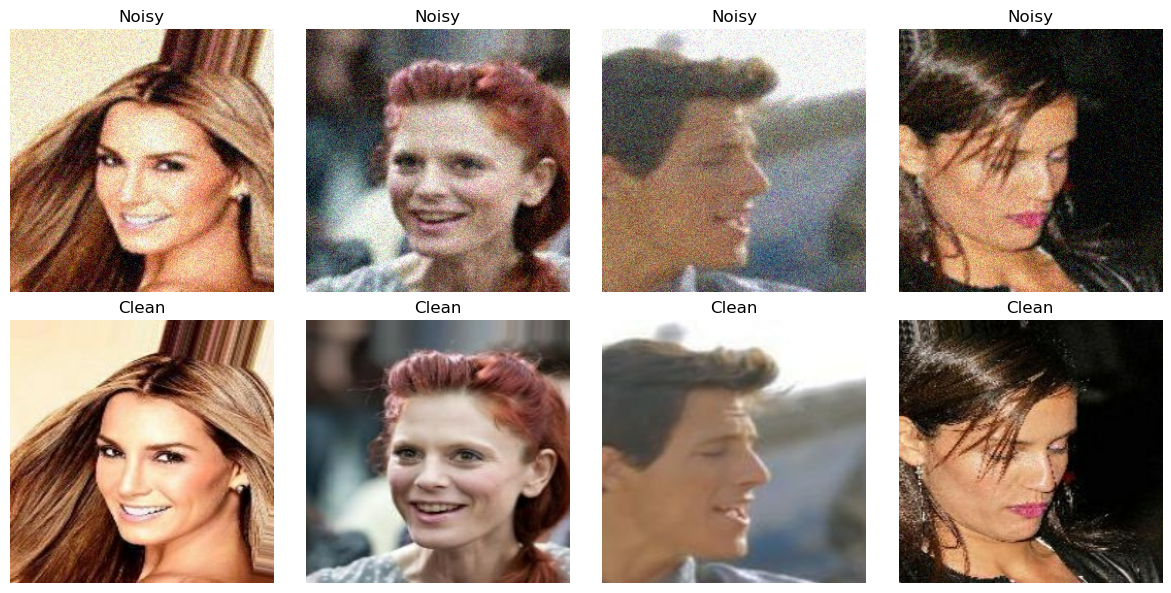

In [3]:
# Get one batch
for noisy_batch, clean_batch in dataset.take(1):
    break

# Plot first few pairs
plt.figure(figsize=(12, 6))
for i in range(4):  # Display 4 pairs
    # Noisy
    plt.subplot(2, 4, i + 1)
    plt.imshow(noisy_batch[i].numpy())
    plt.title("Noisy")
    plt.axis('off')

    # Clean
    plt.subplot(2, 4, i + 5)
    plt.imshow(clean_batch[i].numpy())
    plt.title("Clean")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Split the Dataset

In [4]:
# Assuming `dataset` is already shuffled and batched
DATASET_SIZE = len(filenames)
VAL_SPLIT = 0.1
val_size = int(DATASET_SIZE * VAL_SPLIT)

train_dataset = dataset.skip(val_size)
val_dataset = dataset.take(val_size)

## Model Creation

In [5]:
input_img = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[0], NUM_CHANNELS))  # RGB images

# Initial Conv + ReLU
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = ReLU()(x)

# Downsampling block 1
x1 = Conv2D(64, (3, 3), padding='same')(x)
x1 = BatchNormalization()(x1)
x1 = ReLU()(x1)
p1 = MaxPooling2D(pool_size=(2, 2))(x1)

# Downsampling block 2
x2 = Conv2D(64, (3, 3), padding='same')(p1)
x2 = BatchNormalization()(x2)
x2 = ReLU()(x2)
p2 = MaxPooling2D(pool_size=(2, 2))(x2)

# Middle block 1
x3 = Conv2D(64, (3, 3), padding='same')(p2)
x3 = BatchNormalization()(x3)
x3 = ReLU()(x3)

# Middle block 2
x4 = Conv2D(64, (3, 3), padding='same')(x3)
x4 = BatchNormalization()(x4)
x4 = ReLU()(x4)

# Upsampling block 1 + skip connection with x2
u1 = UpSampling2D(size=(2, 2))(x4)
u1 = Add()([u1, x2])
u1 = Conv2D(64, (3, 3), padding='same')(u1)
u1 = BatchNormalization()(u1)
u1 = ReLU()(u1)

# Upsampling block 2 + skip connection with x1
u2 = UpSampling2D(size=(2, 2))(u1)
u2 = Add()([u2, x1])
u2 = Conv2D(64, (3, 3), padding='same')(u2)
u2 = BatchNormalization()(u2)
u2 = ReLU()(u2)

# Final output layer
output = Conv2D(3, (3, 3), padding='same')(u2)

# Residual connection (input + output)
output_img = Add()([input_img, output])

# Build model
model = Model(inputs=input_img, outputs=output_img)
model.compile(optimizer='adam', loss='mse')
# model.summary()

## Train Model

In [ ]:
epochs = 1

model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)
image_dim = IMAGE_SIZE[0]
model.save(f"trained_models/celeba_udcnn_{image_dim}_{epochs}.keras")

2025-04-02 17:42:19.964771: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-02 17:42:19.964837: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-04-02 17:42:19.964853: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3087801300812466635
2025-04-02 17:42:19.964903: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3294850442951113008
/home/yehia/anaconda3/envs/tf310_env/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` fu